<a href="https://colab.research.google.com/github/Thomas0197/AML/blob/main/AML_Basic_Chinese_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kaggle

In [3]:
mkdir ~/.kaggle

In [4]:
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gpreda/chinese-mnist

 30% 5.00M/16.5M [00:00<00:00, 46.3MB/s]
100% 16.5M/16.5M [00:00<00:00, 80.6MB/s]


In [8]:
!ls


chinese_mnist.csv	 chinese-mnist.zip  drive
chinese_mnist.tfrecords  data		    sample_data


In [ ]:
! unzip chinese-mnist.zip

In [ ]:
model.save('chinese-mnist.h5')

## **AML - BASIC**

# **Introduction**

The dataset comprises of 15,000 images taken of handwritten Chinese numbers. This was done by 100 people writing down 15 Chinese characters 10 times to form 10 ‘samples’ each on A4 paper. They were then scanned and collected by Newcastle University and put available online. The characters make up all that is needed to count from 1 to 100 million. The dataset consists of 15,000 images with the dimensions 64x64. The aim is to classify the images by using Support vector machines (SVM) and Convolutional neural networks (CNN) to determine the number based of the image. 


The meaning of the 15 characters are as follows:



零 - meaning 0

一 - meaning 1

二 - meaning 2

三 - meaning 3

四 - meaning 4

五 - meaning 5

六 - meaning 6

七 - meaning 7

八 - meaning 8

九 - meaning 9

十 - meaning 10

百 - meaning 100

千 - meaning 1000

万 - meaning 10 thousand

亿 - meaning 100 million

A number of libaries are used to help read the images and perform the methods.

# Data preparation

In [9]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
from matplotlib.image import imread
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow

In [10]:
image_path = './data/data/'
image_width = 64
image_height = 64

Reading in the dataset's csv file into a dataframe. The images are kept in a seperate folder and so the file names will need to be added to help with organising the data. The 'suite_id' is used to identify the 100 different people, 'sample_id' refers to each batch containing the 15 characters with each person providing 10 batches. The 'code' is a an ID used to refer to the chinese character(1-15), this will be used later to determin whether the SVM's or CNN correctly classified the image. The 'value' is the actual numeric value of the character

In [11]:
data_df= pd.read_csv("chinese_mnist.csv")
#data_df.shape
data_df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


Checking the CSV contains information for all 15,000 images and the right number for each character

In [12]:
image_files = list(os.listdir(image_path))
print("Total number of images: {}".format(len(image_files)))
print("total number of dataframe rows:", data_df.shape[0])
print("")
data_df.groupby(["code","character"]).size()

Total number of images: 15000
total number of dataframe rows: 15000



code  character
1     零            1000
2     一            1000
3     二            1000
4     三            1000
5     四            1000
6     五            1000
7     六            1000
8     七            1000
9     八            1000
10    九            1000
11    十            1000
12    百            1000
13    千            1000
14    万            1000
15    亿            1000
dtype: int64

To help organise the dataset into training and testing sets the file name is added to the dataframe. Each file is named with the format of input_suiteID_sampleID_code.jpg

In [13]:
def create_file_name(x):
    
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

In [14]:
data_df["file"] = data_df.apply(create_file_name, axis=1)
data_df.head(5)

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


All the images and their numeric value underneath.  

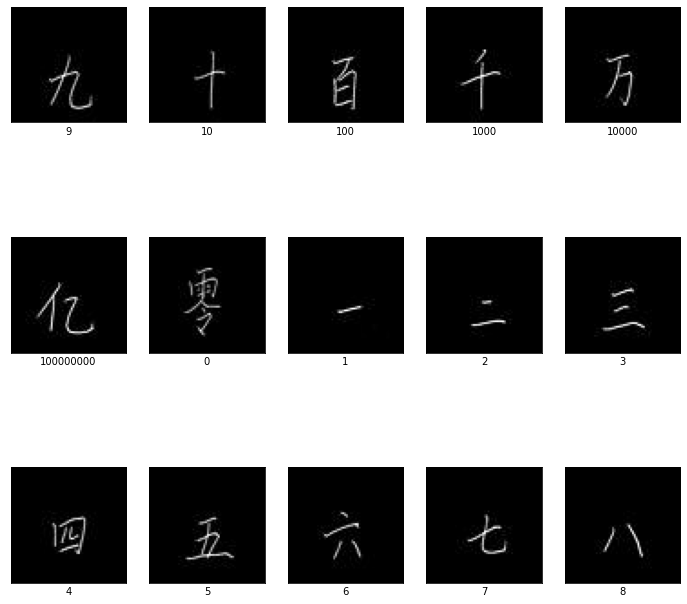

In [15]:
fig=plt.figure(figsize=(12,12))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.xticks([])
  plt.yticks([])
  path = os.path.join(image_path, data_df['file'][i*1000]) #The images are are sorted by the character rather then person, with 1000 characters total 
  path_img = imread(path)
  plt.imshow(path_img, cmap="gray") #images are easier to see in black and white
  plt.xlabel(data_df['value'][i*1000])
plt.show()

A closer look at the very first image in the dataset as an example, this character meaning 9 (九). Image size shown to be 64 by 64

File name:  input_1_1_10.jpg
The character meaning 9 from suite 1


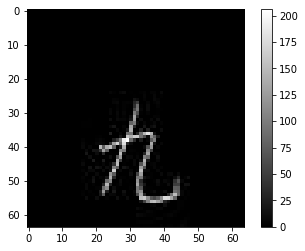

In [16]:
path = os.path.join(image_path, data_df['file'][0])
path_img = imread(path)
plt.imshow(path_img, cmap='gray') #images are easier to see in black and white
plt.colorbar()
print("File name: ",data_df['file'][0])
print("The character meaning 9 from suite 1")

# **Start of SVM**

Support vector machines are a set of supervised learning methods used for classification, regression and outliers detection. Given a training set with the data marked in a category, the SVM algorithm will then build a model that can be used to classify new data (the testing set) to one of the catorgories. Comapared to the other nueral network methods SVM should be less prone to overfitting the data, with the influence of optimal C and gamma parameters. I've looked at 3 different kernels the Gaussian Radial Basis Function (RBF), Polynomial Kernel and Sigmoid kernel to see how each affects the accuracy given the image dataset.

In [17]:
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import cv2 
from sklearn.preprocessing import scale
from sklearn import datasets, svm, metrics

In [ ]:
#list of all the codes
value = data_df["code"].values
print(len(value))

15000


The data for all the images is then read and stored in an numpy array and simultaneously the code value corresponding to the image in the same index.

In [ ]:
#Array to hold a list of all the image properties
image_list = []
#Array to hold a list of all the image 'values' using the code value assigned eg 1 to 15  
code_list = [] 
for i in range(0,len(value)):
  image = skimage.io.imread(image_path + data_df.loc[i,"file"])
  image_list.append(image)
  val = value[i] 
  code_list.append(val)


In [ ]:
#Converting the lists to numpy arrays
image_list = np.array(image_list)
code_list = np.array(code_list)
print(image_list.shape)
print(code_list.shape)


(15000, 64, 64)
(15000,)


The data for the images is then reshaped so that each feature can be read correctly by the SVM. This is done by flattening(transforming it into a 1D array), the data is then normalised to increase the sensitivity and accuracy of the SVM. Using a sklearn function the data is then split into training and testing sets, with a testing set size of 20%. Using stratify the data is split into equal numbers of characters randomly so as to not intorduce any bias towards a particular character

In [ ]:
flattened_image_list = []

for i in range(len(image_list)):
    flattened_image_list.append(image_list[i].flatten()/255) 

flattened_image_list = np.array(flattened_image_list)
#normalising the data again
scaled_flat_image_list = scale(flattened_image_list) 

print(scaled_flat_image_list.shape)

(15000, 4096)


In [ ]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(scaled_flat_image_list, code_list, test_size = 0.2, random_state = 42, stratify=code_list)

print("x_train: ",x_train_svm.shape)
print("y_train: ",y_train_svm.shape)

print("\nx_test: ",x_test_svm.shape)
print("y_test: ",y_test_svm.shape)

x_train:  (12000, 4096)
y_train:  (12000,)

x_test:  (3000, 4096)
y_test:  (3000,)


In [ ]:
y_test_df = pd.DataFrame(data = y_test_svm) 
y_test_df.groupby([0]).size()

0
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
11    200
12    200
13    200
14    200
15    200
dtype: int64

Three SVM's were run to evaulate how the Gaussian Radial Basis Function(rbf), Polynomial kernel and Sigmoid kernel compared. To classify the images as optimally as possible a gridsearch was performed to find the best parameters to run the SVM on, this was done with a cross validation of 5. Due to the length of time needed to run 3 gridsearches, a randomly selected subset (20%) was used as a representation and run on a common range of C and gamma values. To ensure the optimal paramters are found the gridsearch should be run on the proper training set (80% of the dataset) created before instead.   

In [ ]:
#using whole training set causes a worker timeout or memory leak on colabs
x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(scaled_flat_image_list, code_list, test_size = 0.8, random_state = 42)
print(len(x_train_small))

3000


In [ ]:
gamma_range = [0.0001, 0.01, 1.0, 5]
C_range = [0.001, 0.1, 10, 50, 100]

#Variables used to hold all the parameters to search through
parameters_rbf = {'kernel': ['rbf'], 'C':C_range, 'gamma': gamma_range}
parameters_poly = {'kernel': ['poly'], 'C':C_range, 'gamma': gamma_range}
parameters_sigmoid = {'kernel': ['sigmoid'], 'C':C_range, 'gamma': gamma_range}


In [ ]:
#using whole training set causes a worker timeout or memory leak on colabs
grid_rbf = GridSearchCV(estimator=SVC(),param_grid=parameters_rbf, refit = True, verbose=0)
grid_poly = GridSearchCV(estimator=SVC(),param_grid=parameters_poly, refit = True, verbose=0)
grid_sigmoid = GridSearchCV(estimator=SVC(),param_grid=parameters_sigmoid, refit = True, verbose=0)

In [ ]:
#performing the gridsearch
grid_rbf.fit(x_train_small, y_train_small)
grid_poly.fit(x_train_small, y_train_small)
grid_sigmoid.fit(x_train_small, y_train_small)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 10, 50, 100],
                         'gamma': [0.0001, 0.01, 1.0, 5],
                         'kernel': ['sigmoid']})

In [ ]:
#Getting the verbose for the best rbf grid search parameters
params_rbf = grid_rbf.best_params_
CV_rbf = grid_rbf.cv_results_['mean_test_score']

#Getting the verbose for the best poly grid search parameters
params_poly = grid_poly.best_params_
CV_poly = grid_poly.cv_results_['mean_test_score']


#Getting the verbose for the best sigmoid grid search parameters
params_sigmoid = grid_sigmoid.best_params_
CV_sigmoid = grid_sigmoid.cv_results_['mean_test_score']

print("\n Best rbf parameters:\t" + str(params_rbf))
print("\n The mean rbf test scores for the CV:\n" + str(CV_rbf))

print("\n Best poly parameters:\t" + str(params_poly))
print("\n The mean poly test scores for the CV:\n" + str(CV_poly))

print("\n Best sigmoid parameters:\t" + str(params_sigmoid))
print("\n The mean sigmoid test scores for the CV:\n" + str(CV_sigmoid))


 Best rbf parameters:	{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

 The mean rbf test scores for the CV:
[0.07233333 0.07233333 0.07233333 0.07233333 0.11966667 0.07566667
 0.07233333 0.07233333 0.49933333 0.179      0.07233333 0.07233333
 0.47366667 0.179      0.07233333 0.07233333 0.46466667 0.179
 0.07233333 0.07233333]

 Best poly parameters:	{'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}

 The mean poly test scores for the CV:
[0.07233333 0.14733333 0.42866667 0.42866667 0.072      0.40333333
 0.42866667 0.42866667 0.07733333 0.42866667 0.42866667 0.42866667
 0.08633333 0.42866667 0.42866667 0.42866667 0.09566667 0.42866667
 0.42866667 0.42866667]

 Best sigmoid parameters:	{'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}

 The mean sigmoid test scores for the CV:
[0.07233333 0.07233333 0.07233333 0.07233333 0.08466667 0.19866667
 0.07266667 0.074      0.47866667 0.10433333 0.05033333 0.06466667
 0.454      0.10333333 0.054      0.06433333 0.43666667 0.104
 0.05633333 0.065     ]


In [ ]:
#Creating a SVM model and prediction using the rbf kernel
model_rbf = SVC(C=10, gamma=0.0001, kernel="rbf")
model_rbf.fit(x_train_svm, y_train_svm)
pred_rbf = model_rbf.predict(x_test_svm)

#Creating a SVM model and prediction using the poly kernel
model_poly = SVC(C=0.001, gamma=1.0, kernel="poly")
model_poly.fit(x_train_svm, y_train_svm)
pred_poly = model_poly.predict(x_test_svm)

#Creating a SVM model and prediction using the sigmoid kernel
model_sigmoid = SVC(C=10, gamma=0.0001, kernel="sigmoid")
model_sigmoid.fit(x_train_svm, y_train_svm)
pred_sigmoid = model_sigmoid.predict(x_test_svm)

From the resulting 3 models the accuracy of the prediction was calcualted and a confusion matrix plotted to show the results. The kernels perform as expected in relation to other solutions on the web with the rbf kernel overperforming (probably due to to stratifying the data and the paramters chosen). All the kernels however can be seen to have a slight problem with often missclassifying simlar images such as the characters for 1 (一) , 2 (二) and 3 (三).This is the same for mistaking '12' the chinese number for 1000 (千) for 10 (十) as can be seen in the confusion matrix's below. The Polynomial kernel had the best results with an accuracy of 73% and MCC of 71%.

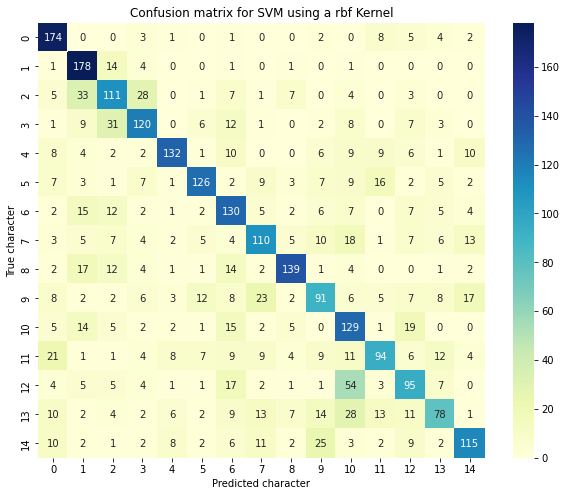

accuracy 0.6073333333333333 



In [ ]:
confusion_rbf = confusion_matrix(y_test_svm, pred_rbf)
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_rbf,annot=True,cmap="YlGnBu",fmt='',ax=ax)
plt.title('Confusion matrix for SVM using a rbf Kernel')
plt.xlabel('Predicted character')
plt.ylabel('True character')
plt.show()

print("accuracy", metrics.accuracy_score(y_test_svm, pred_rbf), "\n")

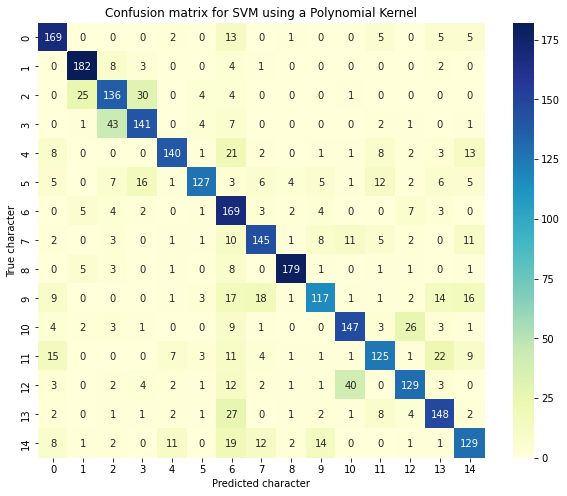

accuracy 0.7276666666666667 



In [ ]:
confusion_poly = confusion_matrix(y_test_svm, pred_poly)
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_poly,annot=True,cmap="YlGnBu",fmt='',ax=ax)
plt.title('Confusion matrix for SVM using a Polynomial Kernel')
plt.xlabel('Predicted character')
plt.ylabel('True character')
plt.show()

print("accuracy", metrics.accuracy_score(y_test_svm, pred_poly), "\n")

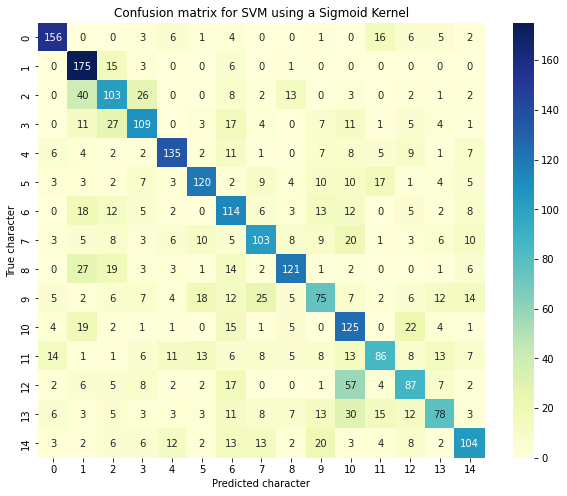

accuracy 0.5636666666666666 



In [ ]:
confusion_sigmoid = confusion_matrix(y_test_svm, pred_sigmoid)
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_sigmoid,annot=True,cmap="YlGnBu",fmt='',ax=ax)
plt.title('Confusion matrix for SVM using a Sigmoid Kernel')
plt.xlabel('Predicted character')
plt.ylabel('True character')
plt.show()

print("accuracy", metrics.accuracy_score(y_test_svm, pred_sigmoid), "\n")

In [ ]:
accuracy_rbf = metrics.accuracy_score(y_test_svm, pred_rbf)
accuracy_poly = metrics.accuracy_score(y_test_svm, pred_poly)
accuracy_sigmoid = metrics.accuracy_score(y_test_svm, pred_sigmoid)

mcc_rbf = metrics.matthews_corrcoef(y_test_svm, pred_rbf)
mcc_poly = metrics.matthews_corrcoef(y_test_svm, pred_poly)
mcc_sigmoid = metrics.matthews_corrcoef(y_test_svm, pred_sigmoid)

accuracies = [accuracy_rbf, accuracy_poly, accuracy_sigmoid]
mccs = [mcc_rbf, mcc_poly, mcc_sigmoid]
pd.DataFrame({'Accuracy': accuracies, 'MCC': mccs,}, 
             index = ['rbf', 'polynomial','sigmoid'])

,Accuracy,MCC
rbf,0.607333,0.580457
polynomial,0.727667,0.709349
sigmoid,0.563667,0.533689


Classification report for the SVM using a Polynomial kernel

In [ ]:
print(metrics.classification_report(y_test_svm, pred_poly))
print('MCC:', mcc_poly)

              precision    recall  f1-score   support

           1       0.75      0.84      0.80       200
           2       0.82      0.91      0.86       200
           3       0.64      0.68      0.66       200
           4       0.71      0.70      0.71       200
           5       0.83      0.70      0.76       200
           6       0.87      0.64      0.73       200
           7       0.51      0.84      0.63       200
           8       0.75      0.72      0.74       200
           9       0.93      0.90      0.91       200
          10       0.76      0.58      0.66       200
          11       0.72      0.73      0.73       200
          12       0.74      0.62      0.68       200
          13       0.72      0.65      0.68       200
          14       0.70      0.74      0.72       200
          15       0.67      0.65      0.66       200

    accuracy                           0.73      3000
   macro avg       0.74      0.73      0.73      3000
weighted avg       0.74   

-------------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------------

# **Start of CNN**

Convolutional neural networks (CNN) is a class of artificial neural network, they are commonly applied for image classification such as the handwritten images of chinese characters in this dataset. 

The CNN works through the mathmatical concept of convolution for which its named, through using convultional layers which takes in inputs such as an image matrix generating activation functions to pass onto the next layer decting more complex features. Which is what is done in the more advanced model to produce a very accurate model. CNN's can be computationally intensive and so max pooling is performed for each layer reducing the dimensions, this also has the benefit of removing some noise. A fully connecter layer is then added with the input matrix flattened(transformed into a 1D array) and fed into a nueral network and epochs run.

In [18]:
import tensorflow as tf
import keras.preprocessing.text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import skimage.transform

Using sklearn again the dataset is split into training and testing sets, with the same testing size of 20% as used in SVM. Stratify is used to ensure an equal proportion of characters across the two sets, so as to not intorduce any possible bias.

In [19]:
#stratify to get equal number of codes
train_df, test_df = train_test_split(data_df, test_size= 0.2, random_state= 42, stratify=data_df["code"].values)
print("Train set rows:",train_df.shape[0])
print("Test  set rows:", test_df.shape[0])

Train set rows: 12000
Test  set rows: 3000


In [20]:
train_df.head()

,suite_id,sample_id,code,value,character,file
11415,46,5,6,5,五,input_46_5_6.jpg
2317,37,7,12,100,百,input_37_7_12.jpg
6232,3,2,1,0,零,input_3_2_1.jpg
11346,4,6,6,5,五,input_4_6_6.jpg
10184,25,4,5,4,四,input_25_4_5.jpg


Reshaping the data to be used for the model later with the image sizes, and the 1 in the channel to signify the images in grey scale. A matrix is created using pd.get_dummies to categorise the characters true value(denoted by a 1) for each image (one hot encoding).

In [21]:
def read_image(file_name):
    image = skimage.io.imread(image_path + file_name)
    image = skimage.transform.resize(image, (image_width, image_height, 1), mode='reflect')
    return image[:,:,:]

In [22]:
def categories_fitter(dataset, var='character'):
    x = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return x, y

In [23]:
x_train, y_train = categories_fitter(train_df)
x_test, y_test = categories_fitter(test_df)

In [24]:
y_train.head()

,一,七,万,三,九,二,五,亿,八,六,十,千,四,百,零
11415,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2317,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11346,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10184,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


A basic model to try and classify the images with two convolutional layers and a simple kernel. As the images are non-linear 'relu' is applied to perform non-linear transformations and to help speed up the training. The Dense/ fully connecter layer uses softmax instead as it calculates the relative probabilty for multiclass classification problems.

The model is then compiled using the popular optimizer 'adam' due to how it adapts the parameter learning rates, as multi-class classification is needed the loss is selected as 'categorical_crossentropy'.

In [25]:
model1=Sequential()
model1.add(Conv2D(16, kernel_size= 3, input_shape=(image_width, image_height, 1), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(16, kernel_size= 3, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 15)                245775    
                                                                 
Total params: 248,255
Trainable params: 248,255
Non-trainable params: 0
__________________________________________________

The model is then created based of the training set. A small number for the epochs and batch size was chosen as to allow the model a chance to miminize the error as it works over the dataset.

In [26]:
train_model1 = model1.fit(x_train, y_train,
                  batch_size= 32,
                  epochs= 5,
                  verbose=1,
                  validation_data=(x_test, y_test))

Epoch 1/5
375/375 [==============================] - 34s 88ms/step - loss: 1.4218 - accuracy: 0.5648 - val_loss: 0.8295 - val_accuracy: 0.7403
Epoch 2/5
375/375 [==============================] - 33s 87ms/step - loss: 0.6565 - accuracy: 0.7914 - val_loss: 0.6306 - val_accuracy: 0.8003
Epoch 3/5
375/375 [==============================] - 33s 87ms/step - loss: 0.4951 - accuracy: 0.8415 - val_loss: 0.5749 - val_accuracy: 0.8260
Epoch 4/5
375/375 [==============================] - 32s 86ms/step - loss: 0.3873 - accuracy: 0.8761 - val_loss: 0.4870 - val_accuracy: 0.8600
Epoch 5/5
375/375 [==============================] - 32s 86ms/step - loss: 0.3069 - accuracy: 0.9024 - val_loss: 0.4336 - val_accuracy: 0.8750


The model accuracy and loss was then plotted based on number of epochs to see the learning rate and gradiant. It is clear the curve has been stopped short and the model could benefit from a larger epoch and batch size.

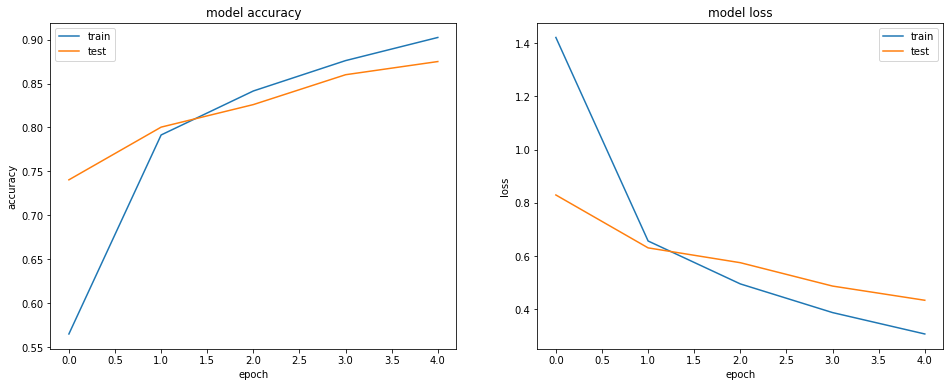

In [27]:
fig=plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(train_model1.history['accuracy'])
plt.plot(train_model1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(train_model1.history['loss'])
plt.plot(train_model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
def classification_report(model):
    predicted = model.predict(x_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    mcc = metrics.matthews_corrcoef(test_truth, test_predicted)
    accuracy = metrics.accuracy_score(test_truth, test_predicted)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    print('MCC:', mcc)
    print('Accuracy:', accuracy)

In [31]:
classification_report(model1)

              precision    recall  f1-score   support

           一       0.92      0.91      0.92       200
           七       0.79      0.93      0.85       200
           万       0.81      0.91      0.85       200
           三       0.90      0.79      0.84       200
           九       0.86      0.74      0.80       200
           二       0.76      0.86      0.81       200
           五       0.93      0.90      0.92       200
           亿       0.86      0.93      0.89       200
           八       0.98      0.98      0.98       200
           六       0.89      0.96      0.93       200
           十       0.76      0.91      0.83       200
           千       0.86      0.71      0.78       200
           四       0.99      0.89      0.94       200
           百       0.91      0.72      0.81       200
           零       0.98      0.99      0.98       200

    accuracy                           0.88      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88   

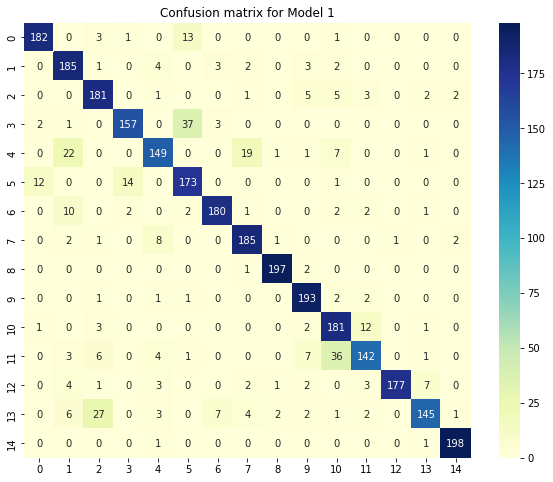

In [32]:
predicted = model1.predict(x_test)
test_predicted = np.argmax(predicted, axis=1)
test_truth = np.argmax(y_test.values, axis=1)
confusion = confusion_matrix(test_truth, test_predicted)

f,ax = plt.subplots(figsize=(10,8))
plt.title('Confusion matrix for Model 1')
plt.xlabel('Predicted character')
plt.ylabel('True character')
sns.heatmap(confusion,annot=True,cmap="YlGnBu",fmt='',ax=ax)
plt.show()

A more advanced model was then created, containing 4 convolutional layers with an increased kernel size and 4 pooling layers. It also has an additional Dense/ fully connected layer compared to the basic. This alongside an improvement in compiling led to a much improved prediction accuracy of 99%.

In [33]:
model2 = Sequential()

model2.add(Conv2D(16, kernel_size= (5,5), input_shape=(image_width, image_height, 1), padding='same', activation='relu')) #1 for the image channel
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(32, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2, 2)))
model2.add(Conv2D(64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2, 2)))
model2.add(Conv2D(128, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(y_train.shape[1], activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        416       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)        

To further increase the accuracy a larger number of epochs was chosen, this is to allow the model to more frequently update it's internal parameters. Alongside a larger batch size to allow the model to pass through the dataset more often.

In [34]:
train_model2  = model2.fit(x_train, y_train,
                  batch_size= 128,
                  epochs= 25,
                  verbose= 1,
                  validation_data=(x_test, y_test))

Epoch 1/25
94/94 [==============================] - 116s 1s/step - loss: 1.4394 - accuracy: 0.5171 - val_loss: 0.4418 - val_accuracy: 0.8483
Epoch 2/25
94/94 [==============================] - 115s 1s/step - loss: 0.3715 - accuracy: 0.8725 - val_loss: 0.2175 - val_accuracy: 0.9233
Epoch 3/25
94/94 [==============================] - 115s 1s/step - loss: 0.2282 - accuracy: 0.9219 - val_loss: 0.1763 - val_accuracy: 0.9377
Epoch 4/25
94/94 [==============================] - 115s 1s/step - loss: 0.1739 - accuracy: 0.9414 - val_loss: 0.1206 - val_accuracy: 0.9603
Epoch 5/25
94/94 [==============================] - 115s 1s/step - loss: 0.1166 - accuracy: 0.9598 - val_loss: 0.0958 - val_accuracy: 0.9640
Epoch 6/25
94/94 [==============================] - 115s 1s/step - loss: 0.0981 - accuracy: 0.9679 - val_loss: 0.0766 - val_accuracy: 0.9757
Epoch 7/25
94/94 [==============================] - 115s 1s/step - loss: 0.0724 - accuracy: 0.9772 - val_loss: 0.0874 - val_accuracy: 0.9707
Epoch 8/25
94

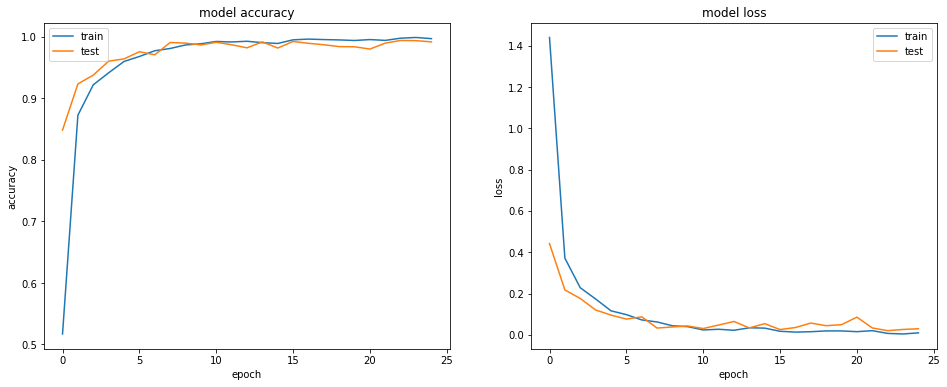

In [35]:
fig=plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(train_model2.history['accuracy'])
plt.plot(train_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(train_model2.history['loss'])
plt.plot(train_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [36]:
classification_report(model2)

              precision    recall  f1-score   support

           一       1.00      1.00      1.00       200
           七       1.00      1.00      1.00       200
           万       0.99      0.99      0.99       200
           三       0.98      1.00      0.99       200
           九       1.00      0.99      1.00       200
           二       1.00      0.97      0.99       200
           五       1.00      0.98      0.99       200
           亿       1.00      1.00      1.00       200
           八       1.00      1.00      1.00       200
           六       1.00      1.00      1.00       200
           十       0.98      0.98      0.98       200
           千       0.98      0.98      0.98       200
           四       0.99      0.99      0.99       200
           百       0.97      0.97      0.97       200
           零       1.00      1.00      1.00       200

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99   

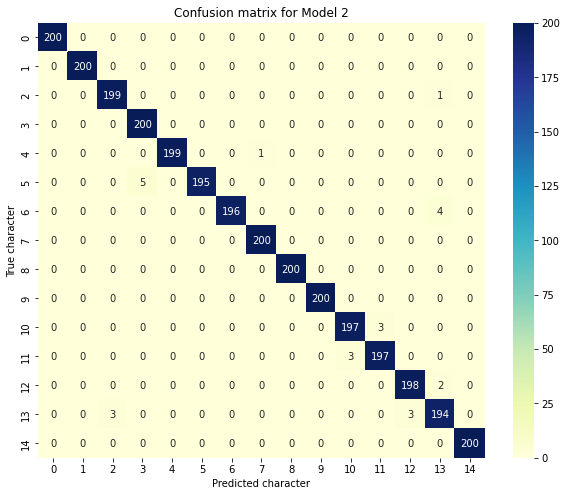

In [37]:
predicted = model2.predict(x_test)
test_predicted = np.argmax(predicted, axis=1)
test_truth = np.argmax(y_test.values, axis=1)
confusion2 = confusion_matrix(test_truth, test_predicted)

f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion2,annot=True,cmap="YlGnBu",fmt='',ax=ax)
plt.title('Confusion matrix for Model 2')
plt.xlabel('Predicted character')
plt.ylabel('True character')
plt.show()

The end results are in line with other solutions found avaiable online. The CNN performed better then the SVM models with even a basic model outperforming the SVM's in significantly less time. Using a more advanced model a very high accuracy was achieved though taking significantly more time to compute. There is also a paper with a Hybrid solution combining both SVM and CNN producing an accuracy of 99% using the same dataset.

END